# Imports

In [1]:
from ebay_delivery_prediction_project import preprocessing, Visualisation, preprocessing_models, postprocessing
preprocessing.import_test()

from datetime import datetime, timedelta

Preprocessing successfully imported.


In [2]:
# data_object = Preprocessing.read_data(rows_to_read = None, columns = ["b2c_c2c"])
# data_object = Preprocessing.read_data(rows_to_read = None)
training_data = preprocessing.read_data(rows_to_read = 100000)["train"]
print(training_data.columns)

Reading 100000 rows.
Reading all columns.
Index(['b2c_c2c', 'seller_id', 'declared_handling_days',
       'acceptance_scan_timestamp', 'shipment_method_id', 'shipping_fee',
       'carrier_min_estimate', 'carrier_max_estimate', 'item_zip', 'buyer_zip',
       'category_id', 'item_price', 'quantity', 'payment_datetime',
       'delivery_date', 'weight', 'weight_units', 'package_size',
       'record_number'],
      dtype='object')


# Setting up pipeline

## Target column

The objective is to estimate the total number of calendar days (after payment) it will take to have a purchased item show up at the buyer’s address. This is equivalent to estimating the delivery date using the formula:

payment date (local time) + delivery calendar days = delivery date (local time).

Participants should provide this delivery date in their submissions.

_Now to generate target column_

### Preprocessing the datetime columns

In [3]:
training_data = preprocessing.parse_datetime_columns(training_data)

### Generating target column "delivery_calendar_days"

In [4]:
training_data = preprocessing.create_delivery_calendar_days(training_data)

In [5]:
training_data["delivery_calendar_days"].describe()

count    100000.000000
mean          4.760280
std           3.067802
min           0.000000
25%           3.000000
50%           4.000000
75%           5.000000
max         101.000000
Name: delivery_calendar_days, dtype: float64

In [6]:
for col in training_data.columns:
    print(f"{col} : {len(training_data[col].unique())}")

b2c_c2c : 2
seller_id : 57971
declared_handling_days : 11
acceptance_scan_timestamp : 88902
shipment_method_id : 17
shipping_fee : 1700
carrier_min_estimate : 6
carrier_max_estimate : 6
item_zip : 16089
buyer_zip : 19592
category_id : 33
item_price : 6518
quantity : 28
payment_datetime : 99878
delivery_date : 667
weight : 318
weight_units : 1
package_size : 5
record_number : 100000
delivery_calendar_days : 82


# Implementing pipeline

## Arbitrarily choosing how to encode columns

In [7]:
different_types_of_encoding = ["one-hot", "numerical"]

cols_and_encoding = {
    "b2c_c2c"   : "one-hot",
    "seller_id"   : 6365,
    "declared_handling_days"   : "numerical",
    "acceptance_scan_timestamp"   : 9848,
    "shipment_method_id"   : "one-hot",
    "shipping_fee"   : "numerical",
    "carrier_min_estimate"   : 4, # Cheating?
    "carrier_max_estimate"   : 5, # Cheating?
    "item_zip"   : 4701, # Needs a lot of preprocessing.
    "buyer_zip"   : 6880, # Needs a lot of preprocessing.
    "category_id"   : 'one-hot', # Only has 33 unique values in 15,000,000 rows so one-hot.
    "item_price"   : "numerical",
    "quantity"   : "numerical",
    "payment_datetime"   : 9998,
    "delivery_date"   : 602,
    "weight"   : "numerical",
    "weight_units"   : 1,
    "package_size"   : "one-hot",
    "record_number"   : 10000,
    "delivery_calendar_days"   : "target",
}

In [8]:
cols_to_convert_to_one_hot = [ele for ele in cols_and_encoding.keys() if cols_and_encoding[ele] == "one-hot"]

print("cols_to_convert_to_one_hot : ", cols_to_convert_to_one_hot)

print("training_data.shape before : ", training_data.shape)
training_data, generated_columns = preprocessing.one_hot_encode_columns(df = training_data, columns = cols_to_convert_to_one_hot)
print("training_data.shape after : ", training_data.shape)

cols_to_convert_to_one_hot :  ['b2c_c2c', 'shipment_method_id', 'category_id', 'package_size']
training_data.shape before :  (100000, 20)
training_data.shape after :  (100000, 73)


In [9]:
target_column = "delivery_calendar_days"
cols_to_use = [ele for ele in cols_and_encoding.keys() if (type(cols_and_encoding[ele]) == str) and
               (cols_and_encoding[ele] != "target") and
               (cols_and_encoding[ele] != "one-hot")]
cols_to_use = [*cols_to_use, *generated_columns]

## Running a gradient boosted decision tree model

In [10]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [11]:
# To define the input and output feature
# x = training_data.drop(['Embarked','PassengerId'],axis=1)
x = training_data[cols_to_use]
y = training_data[target_column]
# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((67000, 62), (33000, 62), (67000,), (33000,))

In [12]:
model = lgb.LGBMRegressor(learning_rate=0.1,max_depth=-5,random_state=42)
model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
          verbose=10,eval_metric='logloss')# This loss needs to mirror the loss that Ebay is using.

/home/swagget/anaconda3/envs/py37/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's l2: 8.52657	valid_0's l2: 7.65328
[20]	training's l2: 8.22455	valid_0's l2: 7.54728
[30]	training's l2: 8.06611	valid_0's l2: 7.55019
[40]	training's l2: 7.94985	valid_0's l2: 7.55045
[50]	training's l2: 7.88762	valid_0's l2: 7.55258
[60]	training's l2: 7.83003	valid_0's l2: 7.55631
[70]	training's l2: 7.78058	valid_0's l2: 7.56552
[80]	training's l2: 7.7478	valid_0's l2: 7.57259
[90]	training's l2: 7.70258	valid_0's l2: 7.57833
[100]	training's l2: 7.66328	valid_0's l2: 7.58713


LGBMRegressor(max_depth=-5, random_state=42)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

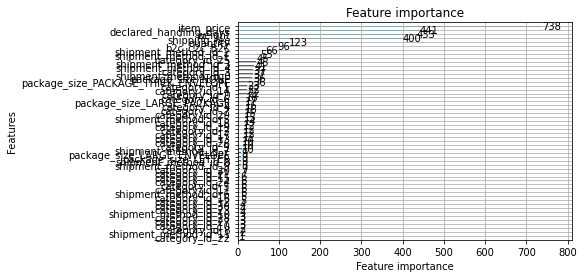

In [13]:
lgb.plot_importance(model)

In [14]:
print('Training accuracy {:.4f}'.format(model.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))

Training accuracy 0.2170
Testing accuracy 0.1226


In [15]:
training_data["model_outputs"] = model.predict(training_data[cols_to_use])

# Postprocessing

After this is all done and predicting with a decent accuracy this needs to be put back and the output needs to predict the delivery date.

The submission is a tsv table, which can be gzipped, with no headeron thw quiz dataset for now. After we win the first phase the test dataset will be given to us.

Each line should contain two values, first the record identifier from the distributed dataset, which is an integer, and second the predicted delivery date as a string in the format YYYY-MM-DD.

All records must be predicted.

In [16]:
output_columns_name = "predicted_delivery_date"

In [17]:
postprocessing.generate_output_column(df = training_data, 
                                      predicted_days_column="model_outputs",
                                     output_columns_name = output_columns_name)

In [18]:
postprocessing.generate_submission_file(df = training_data, predicted_dates_column="predicted_delivery_date")